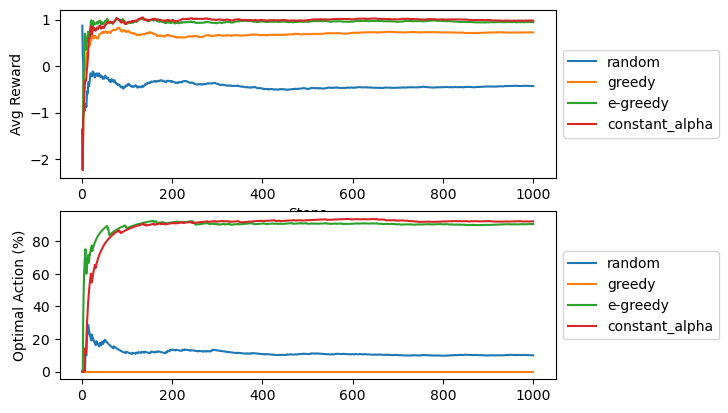

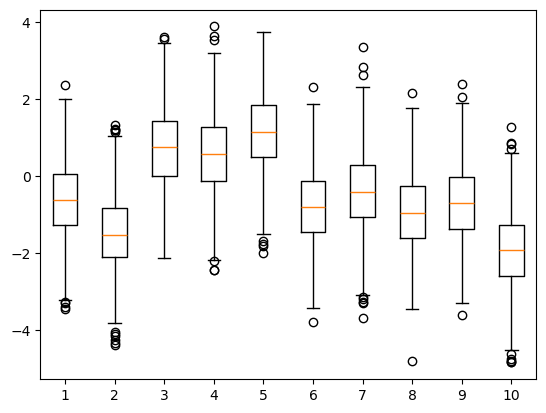

In [18]:
import typing
import random
import numpy as np
import matplotlib.pyplot as plt

k = 10

def default_bandit(a: int) -> float:
    if a == 1:
        return 1.0
    else:
        return 0.0

def distributed_bandit(mean=0, deviation=1, mean_per_action=0, dev_per_action=1) -> float:
    distributed_avgs = [np.random.normal(mean, deviation) for _ in range(k)]

    def bandit(action: int) -> float:
        return distributed_avgs[action-1] + np.random.normal(
            mean_per_action,
            dev_per_action)

    return bandit

def no_epsilon(step: int) -> float:
    return 0

def default_epsilon(step: int) -> float:
    return 0.1

def fixed_epsilon(epsilon: float) -> float:
    def get_epsilon(step: int) -> float:
        return epsilon
    return get_epsilon

def default_alpha(step: int, n: int) -> float:
    return 1/n

def fixed_alpha(alpha: float) -> float:
    def get_alpha(step: int, n: int) -> float:
        return alpha
    return get_alpha

def default_beta(alpha: float, prev_o: float):
    return prev_o + alpha * (1 - prev_o)

def prob_from_preferences(action: int, h: list[float]) -> float:
    return np.exp(h[action-1]) / sum(np.exp(h))

def plot(results: list[tuple[str, list[tuple[int, float, float]]]]) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1)

    for name, result in results:
        steps, avg_r, opt_a = zip(*result)
        ax1.plot(steps, avg_r, '-', label=name)
        ax2.plot(steps, opt_a, '-', label=name)

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Avg Reward')
    ax2.set_ylabel('Optimal Action (%)')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

class Params:
    def __init__(
        self,
        name='default',
        initial_q=0.0,
        get_epsilon: typing.Callable[[int], float] | None = None,
        get_alpha: typing.Callable[[int, int], float] | None = None,
        get_beta: typing.Callable[[float, float], float] | None = None,
        ucb_c=0,
        ucb_maximize=0.01,
        preference=False,
        no_pref_baseline=False,
    ):
        _get_epsilon = get_epsilon or (default_epsilon if not ucb_c else lambda step: 0)
        _get_alpha = get_alpha or (default_alpha if not get_beta else lambda step, n: 0.1)

        self.name = name
        self.initial_q = initial_q
        self.get_epsilon = _get_epsilon
        self.get_alpha = _get_alpha
        self.get_beta = get_beta
        self.ucb_c = ucb_c
        self.ucb_maximize = ucb_maximize
        self.preference = preference
        self.no_pref_baseline = no_pref_baseline

def run(all_rewards: list[list[float]], params: Params, best_action_per_step: bool):
    name = params.name
    initial_q = params.initial_q
    get_epsilon = params.get_epsilon
    get_alpha = params.get_alpha
    get_beta = params.get_beta
    ucb_c = params.ucb_c
    ucb_maximize = params.ucb_maximize
    preference = params.preference
    no_pref_baseline = params.no_pref_baseline

    q = [initial_q] * k
    n = [0] * k
    h = [0] * k
    prev_o = [0] * k
    r_total = 0
    r_avg = 0.0
    opt_total = 0

    avg_actions = [sum(np.array(all_rewards)[:, i]) / len(all_rewards) for i in range(k)]
    best_action_avg = np.argmax(avg_actions) + 1

    result: list[tuple[str, int, float, float]] = []

    for i, rewards in enumerate(all_rewards):
        step = i + 1
        epsilon = get_epsilon(step)

        if random.random() < epsilon:
            a: int = random.randint(1, k)
        elif ucb_c:
            # Upper-Confidence-Bound Action Selection
            val_ucb = [
                (q_i + ucb_c * np.sqrt(np.log(step) / (n_i or ucb_maximize)))
                for q_i, n_i in zip(q, n)
            ]
            a: int = np.argmax(val_ucb) + 1
        elif preference:
            probs = [prob_from_preferences(i+1, h) for i in range(k)]
            a = np.random.choice(range(1, k+1), p=probs)
        else:
            a: int = np.argmax(q) + 1

        r = rewards[a-1]
        n[a-1] += 1

        alpha = get_alpha(step, n[a-1])
        weight = alpha

        if preference:
            probs = [prob_from_preferences(i+1, h) for i in range(k)]
            baseline = 0 if no_pref_baseline else r_avg
            h = [
                (
                    (h_i + alpha * (r - baseline) * (1 - probs[i]))
                    if i == a-1
                    else (h_i - alpha * (r - baseline) * probs[i])
                )
                for i, h_i in enumerate(h)
            ]

        if get_beta:
            beta = get_beta(alpha=alpha, prev_o=prev_o[a-1])
            weight = alpha / beta

        q[a-1] += weight * (r - q[a-1])

        r_total += r
        r_avg = r_total / step
        best_r = max(rewards)
        is_best_a = r == best_r if best_action_per_step else a == best_action_avg
        opt_total += 1 if is_best_a else 0
        opt_percent = 100.0 * opt_total / step
        result.append((step, r_avg, opt_percent))

    return name, result

def main(
    steps=1000,
    bandit=default_bandit,
    best_action_per_step=False,
    plot_rewards=False,
    cases: list[Params] = [],
):
    cases = cases or [Params()]
    all_rewards = [[bandit(i) for i in range(1, k+1)] for step in range(1, steps+1)]
    results = [
        run(all_rewards=all_rewards, params=case, best_action_per_step=best_action_per_step)
        for case in cases
    ]
    plot(results)

    if plot_rewards:
        r_per_a = list(zip(*all_rewards))
        plt.boxplot(r_per_a)
        plt.show()

main(bandit=distributed_bandit(), plot_rewards=True, cases=[
    Params(name='random', get_epsilon=lambda step: 1),
    Params(name='greedy', get_epsilon=lambda step: 0),
    Params(name='e-greedy', get_epsilon=lambda step: 0.1),
    Params(name='constant_alpha', get_epsilon=lambda step: 0.1, get_alpha=lambda step, n: 0.1),
])

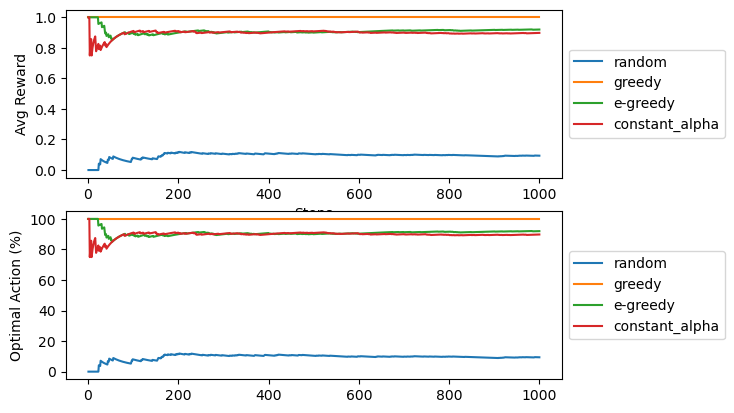

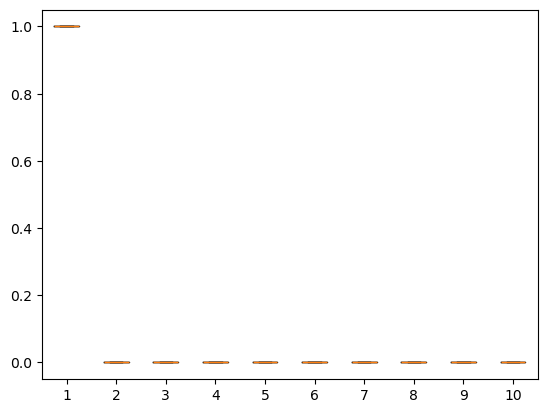

In [19]:
main(bandit=default_bandit, plot_rewards=True, cases=[
    Params(name='random', get_epsilon=lambda step: 1),
    Params(name='greedy', get_epsilon=lambda step: 0),
    Params(name='e-greedy', get_epsilon=lambda step: 0.1),
    Params(name='constant_alpha', get_epsilon=lambda step: 0.1, get_alpha=lambda step, n: 0.1),
])

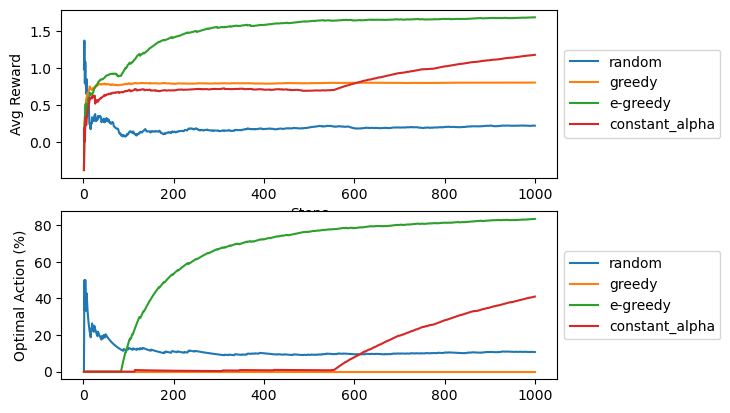

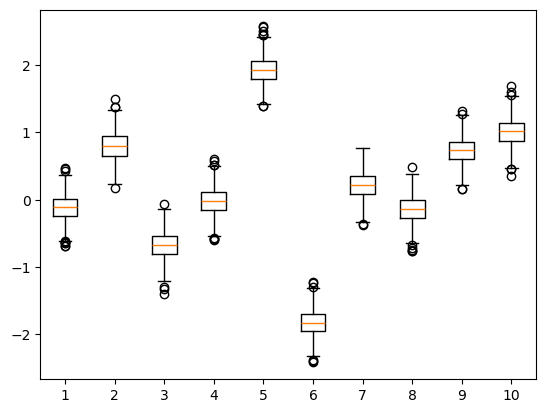

In [20]:
# consider the best action in each step, instead of a single best action overall
# defined with a lesser deviation per action, to more easily define the best action
main(bandit=distributed_bandit(dev_per_action=0.2), best_action_per_step=True, plot_rewards=True, cases=[
    Params(name='random', get_epsilon=lambda step: 1),
    Params(name='greedy', get_epsilon=lambda step: 0),
    Params(name='e-greedy', get_epsilon=lambda step: 0.1),
    Params(name='constant_alpha', get_epsilon=lambda step: 0.1, get_alpha=lambda step, n: 0.1),
])

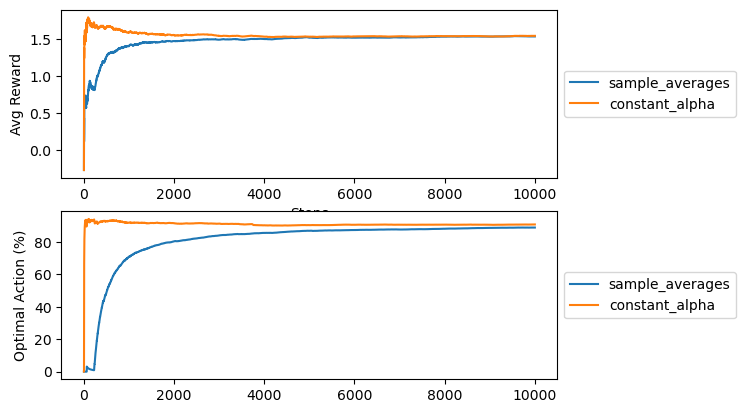

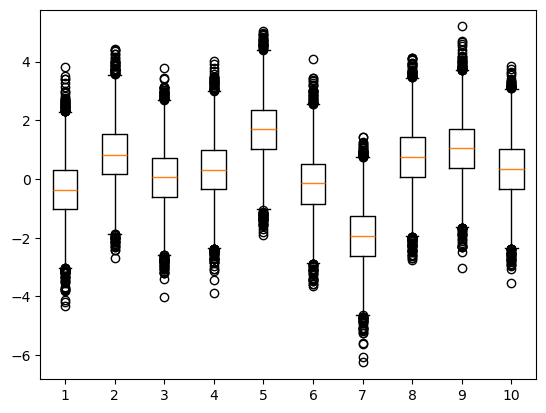

In [21]:
# Exercise 2.5 (pg. 55)
main(steps=10000, bandit=distributed_bandit(), plot_rewards=True, cases=[
    Params(name='sample_averages', get_epsilon=lambda step: 0.1),
    Params(name='constant_alpha', get_epsilon=lambda step: 0.1, get_alpha=lambda step, n: 0.1),
])

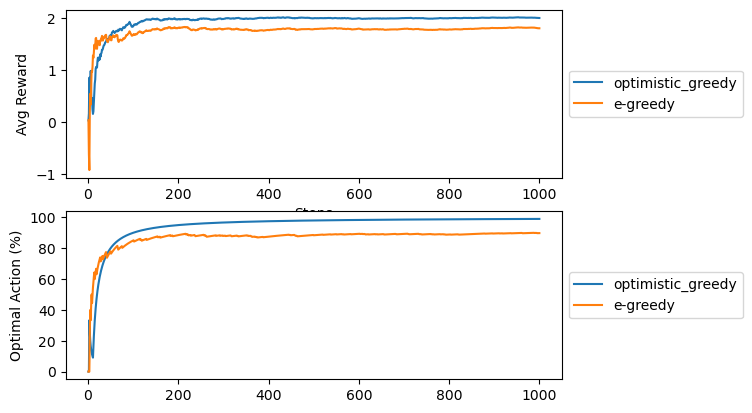

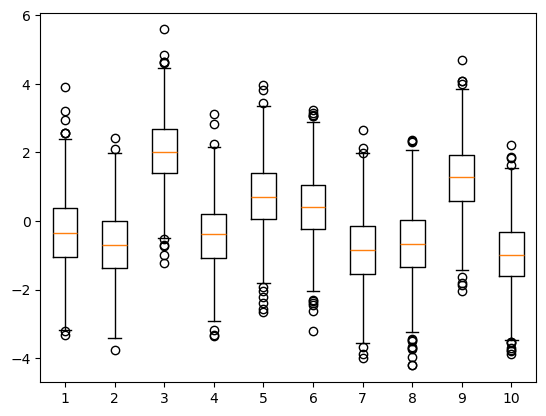

In [22]:
# initial_q=5
main(bandit=distributed_bandit(), plot_rewards=True, cases=[
    Params(name='optimistic_greedy', get_epsilon=lambda step: 0, initial_q=5),
    Params(name='e-greedy', get_epsilon=lambda step: 0.1),
])

### Exercise 2.7

\begin{align*}
\overline{o}_{n} &= \overline{o}_{n-1} + \alpha \cdot (1 - \overline{o}_{n-1}) \\
&=  \overline{o}_{n-1} + \alpha - \alpha \cdot \overline{o}_{n-1} \\
&=  \alpha + (1 - \alpha) \cdot \overline{o}_{n-1} \\
&=  \alpha + (1 - \alpha) \left( \alpha + (1 - \alpha) \cdot \overline{o}_{n-2} \right) \\
&=  \alpha + \alpha \cdot (1 - \alpha) + (1 - \alpha)^2 \cdot \overline{o}_{n-2} \\
&=  \alpha + \alpha \cdot (1 - \alpha) + (1 - \alpha) \left( (1 - \alpha) \cdot \overline{o}_{n-2} \right) \\
&...* \\
&= \alpha + \alpha \cdot (1 - \alpha) + \alpha \cdot (1 - \alpha)^2 + (1 - \alpha)^3 \cdot \overline{o}_{n-3} \\
&... \\
&= \alpha + \alpha \cdot (1 - \alpha) + \alpha \cdot (1 - \alpha)^2 + \alpha \cdot (1 - \alpha)^3 + \ldots + \alpha \cdot (1 - \alpha)^{n-1} + (1 - \alpha)^n \cdot \overline{o}_0 \\
&= \alpha + \alpha \cdot (1 - \alpha) + \alpha \cdot (1 - \alpha)^2 + \alpha \cdot (1 - \alpha)^3 + \ldots + \alpha \cdot (1 - \alpha)^{n-1} \\
&= \sum_{i=0}^{n-1} \alpha \cdot (1 - \alpha)^i
\end{align*}

\begin{align*}
*Obs: (1 - \alpha) \cdot \overline{o}_{n-1} \text{ became } \alpha \cdot (1 - \alpha) + (1 - \alpha)^2 \cdot \overline{o}_{n-2}, \\
\text{ so } (1 - \alpha) \cdot \overline{o}_{n-2} \text{ will become } \alpha \cdot (1 - \alpha) + (1 - \alpha)^2 \cdot \overline{o}_{n-3}
\end{align*}

\begin{equation}
\overline{o}_{n} = \sum_{i=0}^{n-1} \alpha \cdot (1 - \alpha)^i
\end{equation}

\begin{align*}
or
\end{align*}

\begin{equation}
\overline{o}_{n} = \alpha \cdot (1 - \alpha)^{n-1} + \overline{o}_{n-1}
\end{equation}

\begin{align*}
\text{this means that the most recent reward will have a slightly higher weight than the previous, and so on, }
\end{align*}

\begin{align*}
\text{but the increase of weight reduces exponentially with the number of steps}
\end{align*}

\begin{align*}
\text{so, } \beta_{n} = \alpha/\overline{o}_{n} \text{ will decrease with n, but very little due to the exponential nature of } \overline{o}_{n}
\end{align*}

\begin{align*}
\text{Also, } \overline{o}_{n} \text{ converges to 1 as n increases, according to the following:}
\end{align*}

\begin{align*}
\overline{o}_{n} &= \sum_{i=0}^{n-1} \alpha \cdot (1 - \alpha)^i \\
&= \alpha + \alpha \cdot (1 - \alpha) + \alpha \cdot (1 - \alpha)^2 + ... + \alpha \cdot (1 - \alpha)^{n-1}
\end{align*}

\begin{align*}
\text{so}
\end{align*}

\begin{align*}
\overline{o}_{n} - (1 - \alpha) \cdot \overline{o}_{n} = \alpha - \alpha \cdot (1 - \alpha)^n \\
\alpha \cdot \overline{o}_{n} = \alpha \cdot (1 - (1 - \alpha)^n) \\
\overline{o}_{n} = 1 - (1 - \alpha)^n
\end{align*}

\begin{align*}
\overline{o}_{n} \text{ increases each time less as n increases, converging to 1 as n goes to infinity, because } |1 - \alpha| < 1
\end{align*}

\begin{align*}
\text{Which means that } \beta_{n} = \alpha / \overline{o}_{n} \text{ starts with value } \beta_1 = 1 \text{ (} \overline{o}_{1} = \alpha \text{)}
\end{align*}

\begin{align*}
\text{and converges to } \alpha \text{ (} \overline{o}_{n} \text{ converges to 1, as explained above) as n goes to infinity, }
\end{align*}

\begin{align*}
\text{while sample averages starts with 1 and converges to 0 (because 1/n converges to 0)}
\end{align*}

\begin{align*}
\text{This means that using sample averages, the reward in later steps has almost no impact on } Q_n \text{,}
\end{align*}

\begin{align*}
\text{while using } \beta_n \text{, no matter how big is n, the current reward will still have a weight of at least } \alpha
\end{align*}

\begin{align*}
\text{(with the sum of the weights being 1).}
\end{align*}

\begin{align*}
\text{Applying a reasoning similar to 2.6, we have:}
\end{align*}

\begin{align*}
Q_{n+1} &= Q_n + \beta_n \cdot [R_n - Q_n] \\
&= \beta_n \cdot R_n + (1 - \beta_n) \cdot Q_n \\
&= \beta_n \cdot R_n + (1 - \beta_n) \cdot [\beta_{n-1} \cdot R_{n-1} + (1 - \beta_{n-1}) \cdot Q_{n-1}] \\
&= \beta_n \cdot R_n + (1 - \beta_n) \cdot \beta_{n-1} \cdot R_{n-1} + (1 - \beta_n)(1 - \beta_{n-1}) \cdot Q_{n-1} \\
&= \beta_n \cdot R_n + (1 - \beta_n) \cdot \beta_{n-1} \cdot R_{n-1} + (1 - \beta_n)(1 - \beta_{n-1}) \cdot \beta_{n-2} \cdot R_{n-2} + \\
&... + [\prod_{i=2}^n (1 - \beta_i) ] \cdot \beta_1 \cdot R_1 + [\prod_{i=1}^n (1 - \beta_i) ] \cdot Q_1 \\
&= [\prod_{i=1}^n (1 - \beta_i) ] \cdot Q_1 + \sum_{i=1}^n [\prod_{j=i+1}^n (1 - \beta_j) ] \cdot \beta_i \cdot R_i
\end{align*}

\begin{align*}
\text{with } \prod_{j=k}^n (1 - \beta_j) = 1 \text{ if } k > n \text{ (Empty Product Convention)}
\end{align*}

\begin{align*}
\text{but } \beta_1 = 1 \text{ (as said above) and, consequently, } 1 - B_1 = 0 \text{, so:}
\end{align*}

\begin{align*}
Q_{n+1} =  \sum_{i=1}^n [\prod_{j=i+1}^n (1 - \beta_j) ] \cdot \beta_i \cdot R_i
\end{align*}

\begin{align*}
\text{which does not have an initial bias (does not depend on } Q_1 \text{)}
\end{align*}




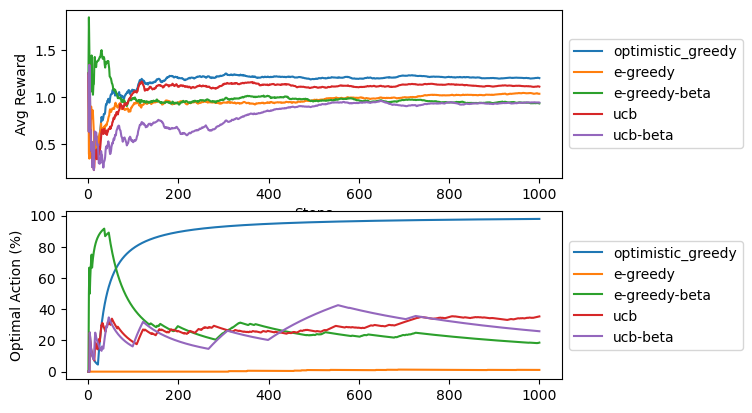

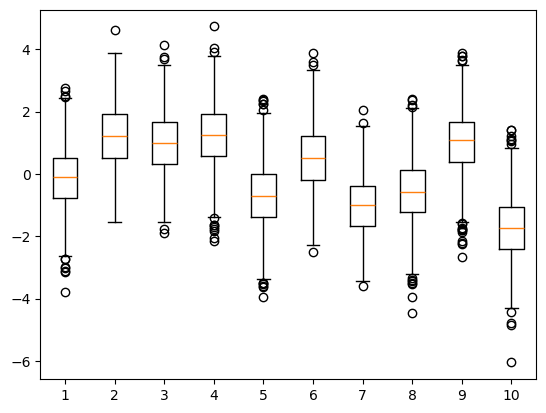

In [23]:
# [section 2.7] Upper-Confidence-Bound Action Selection
main(bandit=distributed_bandit(), plot_rewards=True, cases=[
    Params(name='optimistic_greedy', get_epsilon=lambda step: 0, initial_q=5),
    Params(name='e-greedy', get_epsilon=lambda step: 0.1),
    Params(name='e-greedy-beta', get_epsilon=lambda step: 0.1, get_beta=default_beta),
    Params(name='ucb', ucb_c=2),
    Params(name='ucb-beta', ucb_c=2, get_beta=default_beta),
])

### Exercise 2.9

The sigmoid function is defined as:

\begin{align*}
σ(x) = \frac{1}{1 + e^{-x}}
\end{align*}

The softmax distribution of action probabilities is defined as:

\begin{align*}
Pr\{A_t=a\} = \pi_t(a) = \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}}
\end{align*}

In the case of 2 actions `a=1` and `b=2`, we have the softmax function:

\begin{align*}
Pr\{A_t=a\} = \pi_t(a) = \frac{e^{H_t(a)}}{\sum_{i=1}^2 e^{H_t(i)}} = \frac{e^{H_t(a)}}{e^{H_t(a)} + e^{H_t(b)}} = \frac{1}{1 + \frac{e^{H_t(b)}}{e^{H_t(a)}}} = \frac{1}{1 + e^{{H_t(b)} - {H_t(a)}}}
\end{align*}

So we have: 

\begin{align*}
\pi_t(a) = \frac{1}{1 + e^{- ({H_t(a)} - {H_t(b)})}}
\end{align*}

Which means that the softmax function with 2 actions, `a` and `b`, is the same as the sigmoid function:

\begin{align*}
\pi_t(a) = σ({H_t(a)} - {H_t(b)})
\end{align*}

Where ${H_t(a)} - {H_t(b)}$ is the relative preference of `a` over `b`.

And correspondingly:

\begin{align*}
\pi_t(b) = σ({H_t(b)} - {H_t(a)})
\end{align*}

It's also important to note that the sum of the probabilities for all actions is always 1 (for any number of actions, not only for the specific case of 2 actions):

\begin{align*}
\sum_{a=1}^k \pi_t(a) = \sum_{a=1}^k \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}} = \frac{\sum_{a=1}^k e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}} = 1
\end{align*}



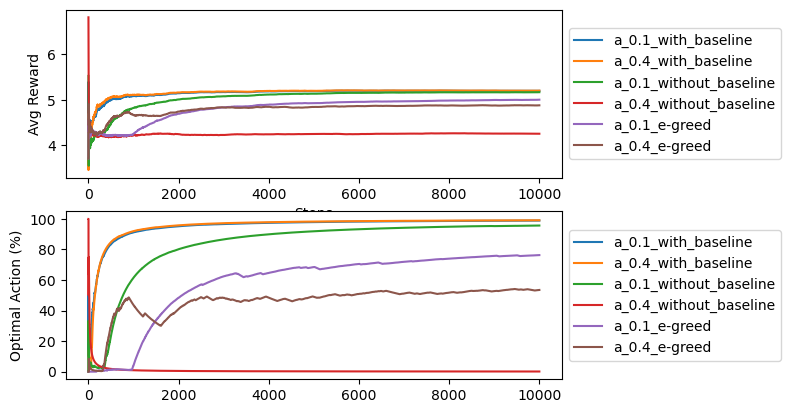

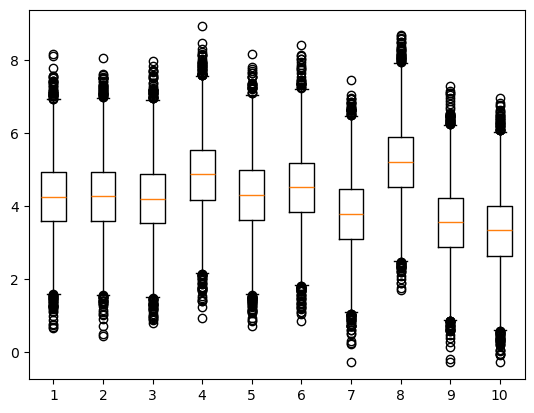

In [29]:
# [section 2.8] Gradient Bandit Algorithms
main(steps=10000, bandit=distributed_bandit(mean=4, deviation=1), plot_rewards=True, cases=[
    Params(name='a_0.1_with_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.1), preference=True),
    Params(name='a_0.4_with_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.4), preference=True),
    Params(name='a_0.1_without_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.1), preference=True, no_pref_baseline=True),
    Params(name='a_0.4_without_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.4), preference=True, no_pref_baseline=True),
    Params(name='a_0.1_e-greed', get_epsilon=fixed_epsilon(0.1), get_alpha=fixed_alpha(0.1)),
    Params(name='a_0.4_e-greed', get_epsilon=fixed_epsilon(0.1), get_alpha=fixed_alpha(0.4)),
])

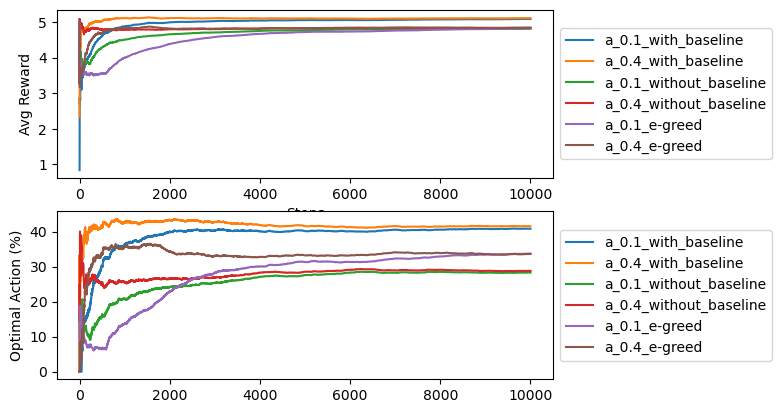

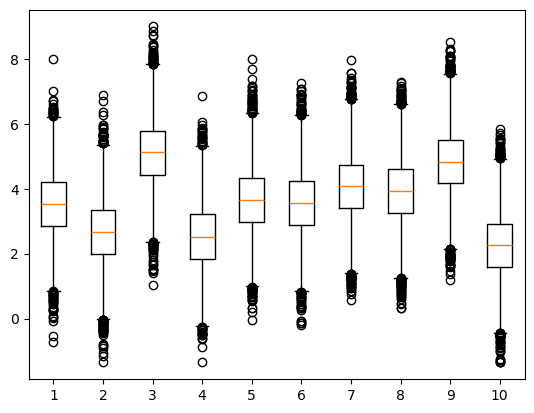

In [30]:
# [section 2.8] Gradient Bandit Algorithms (considering the best action per step, instead of the best average for all steps)
main(steps=10000, bandit=distributed_bandit(mean=4, deviation=1), best_action_per_step=True, plot_rewards=True, cases=[
    Params(name='a_0.1_with_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.1), preference=True),
    Params(name='a_0.4_with_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.4), preference=True),
    Params(name='a_0.1_without_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.1), preference=True, no_pref_baseline=True),
    Params(name='a_0.4_without_baseline', get_epsilon=no_epsilon, get_alpha=fixed_alpha(0.4), preference=True, no_pref_baseline=True),
    Params(name='a_0.1_e-greed', get_epsilon=fixed_epsilon(0.1), get_alpha=fixed_alpha(0.1)),
    Params(name='a_0.4_e-greed', get_epsilon=fixed_epsilon(0.1), get_alpha=fixed_alpha(0.4)),
])